# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 6234112/11490434 [===============>..............] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:50 - loss: 0.6941

  34/1875 [..............................] - ETA: 2s - loss: 0.5283   

  65/1875 [>.............................] - ETA: 2s - loss: 0.4543

  99/1875 [>.............................] - ETA: 2s - loss: 0.4117

 130/1875 [=>............................] - ETA: 2s - loss: 0.3869

 158/1875 [=>............................] - ETA: 2s - loss: 0.3701

 187/1875 [=>............................] - ETA: 2s - loss: 0.3562

 216/1875 [==>...........................] - ETA: 2s - loss: 0.3447

 246/1875 [==>...........................] - ETA: 2s - loss: 0.3345

 274/1875 [===>..........................] - ETA: 2s - loss: 0.3263

 303/1875 [===>..........................] - ETA: 2s - loss: 0.3187

 332/1875 [====>.........................] - ETA: 2s - loss: 0.3120

 364/1875 [====>.........................] - ETA: 2s - loss: 0.3052

 401/1875 [=====>........................] - ETA: 2s - loss: 0.2982

 434/1875 [=====>........................] - ETA: 2s - loss: 0.2926

 467/1875 [======>.......................] - ETA: 2s - loss: 0.2875

 505/1875 [=======>......................] - ETA: 2s - loss: 0.2821

 541/1875 [=======>......................] - ETA: 2s - loss: 0.2774

 572/1875 [========>.....................] - ETA: 2s - loss: 0.2736

 604/1875 [========>.....................] - ETA: 2s - loss: 0.2699

 635/1875 [=========>....................] - ETA: 1s - loss: 0.2666

 666/1875 [=========>....................] - ETA: 1s - loss: 0.2634

 694/1875 [==========>...................] - ETA: 1s - loss: 0.2608

 728/1875 [==========>...................] - ETA: 1s - loss: 0.2576

 757/1875 [===========>..................] - ETA: 1s - loss: 0.2551

 788/1875 [===========>..................] - ETA: 1s - loss: 0.2526

 818/1875 [============>.................] - ETA: 1s - loss: 0.2502

 848/1875 [============>.................] - ETA: 1s - loss: 0.2479

 877/1875 [=============>................] - ETA: 1s - loss: 0.2458

 902/1875 [=============>................] - ETA: 1s - loss: 0.2441

 926/1875 [=============>................] - ETA: 1s - loss: 0.2424

 952/1875 [==============>...............] - ETA: 1s - loss: 0.2407

 977/1875 [==============>...............] - ETA: 1s - loss: 0.2391

1002/1875 [===============>..............] - ETA: 1s - loss: 0.2376

1027/1875 [===============>..............] - ETA: 1s - loss: 0.2361

1054/1875 [===============>..............] - ETA: 1s - loss: 0.2345

1082/1875 [================>.............] - ETA: 1s - loss: 0.2329

1109/1875 [================>.............] - ETA: 1s - loss: 0.2315

1136/1875 [=================>............] - ETA: 1s - loss: 0.2300

1165/1875 [=================>............] - ETA: 1s - loss: 0.2285

1192/1875 [==================>...........] - ETA: 1s - loss: 0.2272

1221/1875 [==================>...........] - ETA: 1s - loss: 0.2258

1253/1875 [===================>..........] - ETA: 1s - loss: 0.2243

1285/1875 [===================>..........] - ETA: 1s - loss: 0.2228

1315/1875 [====================>.........] - ETA: 0s - loss: 0.2215

1346/1875 [====================>.........] - ETA: 0s - loss: 0.2201

1378/1875 [=====================>........] - ETA: 0s - loss: 0.2188

1410/1875 [=====================>........] - ETA: 0s - loss: 0.2175

1437/1875 [=====================>........] - ETA: 0s - loss: 0.2164

1467/1875 [======================>.......] - ETA: 0s - loss: 0.2153

1495/1875 [======================>.......] - ETA: 0s - loss: 0.2142

1525/1875 [=======================>......] - ETA: 0s - loss: 0.2131

1543/1875 [=======================>......] - ETA: 0s - loss: 0.2124

1569/1875 [========================>.....] - ETA: 0s - loss: 0.2115

1594/1875 [========================>.....] - ETA: 0s - loss: 0.2106

1615/1875 [========================>.....] - ETA: 0s - loss: 0.2099

1643/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1670/1875 [=========================>....] - ETA: 0s - loss: 0.2081

1694/1875 [==========================>...] - ETA: 0s - loss: 0.2073

1720/1875 [==========================>...] - ETA: 0s - loss: 0.2065

1748/1875 [==========================>...] - ETA: 0s - loss: 0.2056

1774/1875 [===========================>..] - ETA: 0s - loss: 0.2048

1797/1875 [===========================>..] - ETA: 0s - loss: 0.2041

1827/1875 [============================>.] - ETA: 0s - loss: 0.2033

1854/1875 [============================>.] - ETA: 0s - loss: 0.2025

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2019


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1068

  30/1875 [..............................] - ETA: 3s - loss: 0.1087

  56/1875 [..............................] - ETA: 3s - loss: 0.1088

  84/1875 [>.............................] - ETA: 3s - loss: 0.1089

 116/1875 [>.............................] - ETA: 3s - loss: 0.1089

 147/1875 [=>............................] - ETA: 3s - loss: 0.1088

 175/1875 [=>............................] - ETA: 3s - loss: 0.1088

 205/1875 [==>...........................] - ETA: 3s - loss: 0.1087

 237/1875 [==>...........................] - ETA: 2s - loss: 0.1087

 267/1875 [===>..........................] - ETA: 2s - loss: 0.1086

 299/1875 [===>..........................] - ETA: 2s - loss: 0.1085

 330/1875 [====>.........................] - ETA: 2s - loss: 0.1084

 362/1875 [====>.........................] - ETA: 2s - loss: 0.1084

 394/1875 [=====>........................] - ETA: 2s - loss: 0.1083

 425/1875 [=====>........................] - ETA: 2s - loss: 0.1082

 457/1875 [======>.......................] - ETA: 2s - loss: 0.1081

 489/1875 [======>.......................] - ETA: 2s - loss: 0.1080

 521/1875 [=======>......................] - ETA: 2s - loss: 0.1079

 552/1875 [=======>......................] - ETA: 2s - loss: 0.1079

 584/1875 [========>.....................] - ETA: 2s - loss: 0.1078

 616/1875 [========>.....................] - ETA: 2s - loss: 0.1077

 649/1875 [=========>....................] - ETA: 2s - loss: 0.1076

 682/1875 [=========>....................] - ETA: 1s - loss: 0.1075

 715/1875 [==========>...................] - ETA: 1s - loss: 0.1075

 747/1875 [==========>...................] - ETA: 1s - loss: 0.1074

 779/1875 [===========>..................] - ETA: 1s - loss: 0.1073

 812/1875 [===========>..................] - ETA: 1s - loss: 0.1072

 844/1875 [============>.................] - ETA: 1s - loss: 0.1072

 876/1875 [=============>................] - ETA: 1s - loss: 0.1071

 909/1875 [=============>................] - ETA: 1s - loss: 0.1070

 942/1875 [==============>...............] - ETA: 1s - loss: 0.1070

 975/1875 [==============>...............] - ETA: 1s - loss: 0.1069

1008/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1041/1875 [===============>..............] - ETA: 1s - loss: 0.1067

1073/1875 [================>.............] - ETA: 1s - loss: 0.1067

1105/1875 [================>.............] - ETA: 1s - loss: 0.1066

1133/1875 [=================>............] - ETA: 1s - loss: 0.1066

1160/1875 [=================>............] - ETA: 1s - loss: 0.1065

1188/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1214/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1244/1875 [==================>...........] - ETA: 1s - loss: 0.1063

1269/1875 [===================>..........] - ETA: 1s - loss: 0.1063

1296/1875 [===================>..........] - ETA: 0s - loss: 0.1062

1317/1875 [====================>.........] - ETA: 0s - loss: 0.1062

1342/1875 [====================>.........] - ETA: 0s - loss: 0.1061

1364/1875 [====================>.........] - ETA: 0s - loss: 0.1061

1394/1875 [=====================>........] - ETA: 0s - loss: 0.1060

1423/1875 [=====================>........] - ETA: 0s - loss: 0.1060

1451/1875 [======================>.......] - ETA: 0s - loss: 0.1059

1480/1875 [======================>.......] - ETA: 0s - loss: 0.1059

1509/1875 [=======================>......] - ETA: 0s - loss: 0.1058

1532/1875 [=======================>......] - ETA: 0s - loss: 0.1058

1563/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1593/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1056

1654/1875 [=========================>....] - ETA: 0s - loss: 0.1056

1684/1875 [=========================>....] - ETA: 0s - loss: 0.1055

1714/1875 [==========================>...] - ETA: 0s - loss: 0.1055

1745/1875 [==========================>...] - ETA: 0s - loss: 0.1054

1771/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1803/1875 [===========================>..] - ETA: 0s - loss: 0.1053

1832/1875 [============================>.] - ETA: 0s - loss: 0.1053

1856/1875 [============================>.] - ETA: 0s - loss: 0.1053

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1052


Epoch 3/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0989

  24/1875 [..............................] - ETA: 4s - loss: 0.1006

  53/1875 [..............................] - ETA: 3s - loss: 0.0999

  81/1875 [>.............................] - ETA: 3s - loss: 0.0996

 110/1875 [>.............................] - ETA: 3s - loss: 0.0993

 139/1875 [=>............................] - ETA: 3s - loss: 0.0991

 167/1875 [=>............................] - ETA: 3s - loss: 0.0989

 192/1875 [==>...........................] - ETA: 3s - loss: 0.0988

 221/1875 [==>...........................] - ETA: 3s - loss: 0.0987

 248/1875 [==>...........................] - ETA: 3s - loss: 0.0987

 268/1875 [===>..........................] - ETA: 3s - loss: 0.0986

 299/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 327/1875 [====>.........................] - ETA: 2s - loss: 0.0985

 355/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 378/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 432/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 486/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 508/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 554/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 640/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 666/1875 [=========>....................] - ETA: 2s - loss: 0.0981

 690/1875 [==========>...................] - ETA: 2s - loss: 0.0981

 715/1875 [==========>...................] - ETA: 2s - loss: 0.0981

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0981

 765/1875 [===========>..................] - ETA: 2s - loss: 0.0981

 790/1875 [===========>..................] - ETA: 2s - loss: 0.0981

 818/1875 [============>.................] - ETA: 2s - loss: 0.0980

 843/1875 [============>.................] - ETA: 2s - loss: 0.0980

 872/1875 [============>.................] - ETA: 1s - loss: 0.0980

 903/1875 [=============>................] - ETA: 1s - loss: 0.0980

 931/1875 [=============>................] - ETA: 1s - loss: 0.0980

 956/1875 [==============>...............] - ETA: 1s - loss: 0.0980

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0980

1010/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1040/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1072/1875 [================>.............] - ETA: 1s - loss: 0.0979

1096/1875 [================>.............] - ETA: 1s - loss: 0.0979

1123/1875 [================>.............] - ETA: 1s - loss: 0.0979

1149/1875 [=================>............] - ETA: 1s - loss: 0.0979

1176/1875 [=================>............] - ETA: 1s - loss: 0.0979

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1238/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1270/1875 [===================>..........] - ETA: 1s - loss: 0.0979

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1334/1875 [====================>.........] - ETA: 1s - loss: 0.0978

1358/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0978

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1641/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0977

1834/1875 [============================>.] - ETA: 0s - loss: 0.0977

1859/1875 [============================>.] - ETA: 0s - loss: 0.0977

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0976


Epoch 4/5
   1/1875 [..............................] - ETA: 9s - loss: 0.0981

  29/1875 [..............................] - ETA: 3s - loss: 0.0960

  58/1875 [..............................] - ETA: 3s - loss: 0.0962

  82/1875 [>.............................] - ETA: 3s - loss: 0.0963

 112/1875 [>.............................] - ETA: 3s - loss: 0.0964

 140/1875 [=>............................] - ETA: 3s - loss: 0.0964

 166/1875 [=>............................] - ETA: 3s - loss: 0.0964

 193/1875 [==>...........................] - ETA: 3s - loss: 0.0964

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0965

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0965

 267/1875 [===>..........................] - ETA: 3s - loss: 0.0965

 290/1875 [===>..........................] - ETA: 3s - loss: 0.0965

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0964

 338/1875 [====>.........................] - ETA: 3s - loss: 0.0964

 363/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 389/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 433/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 487/1875 [======>.......................] - ETA: 2s - loss: 0.0964

 520/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 627/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 713/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 742/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 769/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 795/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 819/1875 [============>.................] - ETA: 2s - loss: 0.0963

 846/1875 [============>.................] - ETA: 1s - loss: 0.0963

 871/1875 [============>.................] - ETA: 1s - loss: 0.0963

 903/1875 [=============>................] - ETA: 1s - loss: 0.0963

 935/1875 [=============>................] - ETA: 1s - loss: 0.0963

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0963

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1032/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1065/1875 [================>.............] - ETA: 1s - loss: 0.0962

1097/1875 [================>.............] - ETA: 1s - loss: 0.0962

1129/1875 [=================>............] - ETA: 1s - loss: 0.0962

1159/1875 [=================>............] - ETA: 1s - loss: 0.0962

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0962

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0962

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1535/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1813/1875 [============================>.] - ETA: 0s - loss: 0.0961

1845/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0966

  34/1875 [..............................] - ETA: 2s - loss: 0.0946

  65/1875 [>.............................] - ETA: 2s - loss: 0.0946

  96/1875 [>.............................] - ETA: 2s - loss: 0.0946

 128/1875 [=>............................] - ETA: 2s - loss: 0.0947

 158/1875 [=>............................] - ETA: 2s - loss: 0.0949

 190/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 223/1875 [==>...........................] - ETA: 2s - loss: 0.0951

 254/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 286/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 318/1875 [====>.........................] - ETA: 2s - loss: 0.0951

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0952

 382/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 414/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 509/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 540/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 604/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 636/1875 [=========>....................] - ETA: 1s - loss: 0.0953

 668/1875 [=========>....................] - ETA: 1s - loss: 0.0953

 700/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 732/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 763/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 794/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 825/1875 [============>.................] - ETA: 1s - loss: 0.0953

 857/1875 [============>.................] - ETA: 1s - loss: 0.0953

 889/1875 [=============>................] - ETA: 1s - loss: 0.0953

 922/1875 [=============>................] - ETA: 1s - loss: 0.0953

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1054/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1087/1875 [================>.............] - ETA: 1s - loss: 0.0952

1118/1875 [================>.............] - ETA: 1s - loss: 0.0952

1150/1875 [=================>............] - ETA: 1s - loss: 0.0952

1182/1875 [=================>............] - ETA: 1s - loss: 0.0952

1216/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1249/1875 [==================>...........] - ETA: 0s - loss: 0.0952

1282/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1316/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1349/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1380/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1444/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1509/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1831/1875 [============================>.] - ETA: 0s - loss: 0.0952

1862/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

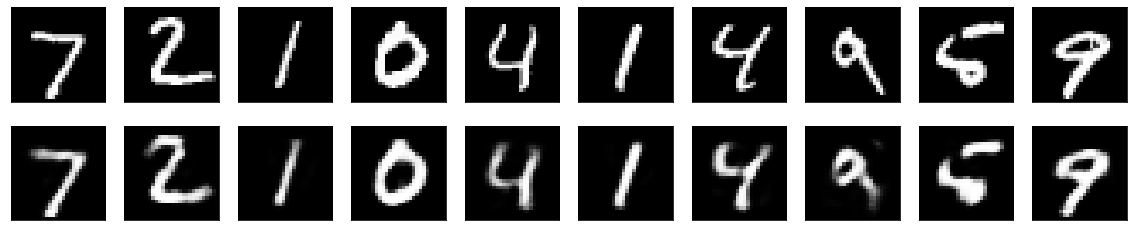

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
